In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [56]:
df = pd.read_csv("PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [57]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


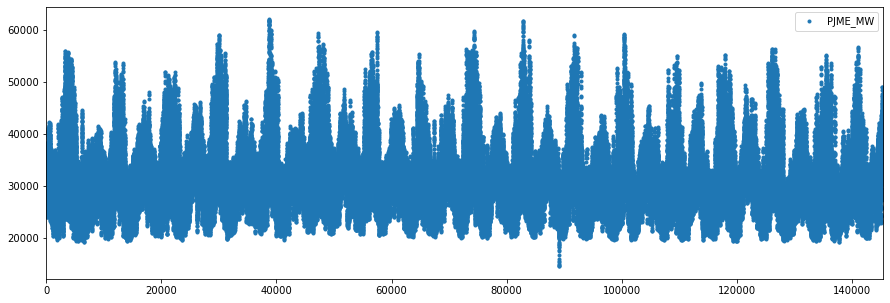

In [58]:
#2002den 2018e kadar olan saatbaşı elektrik kullanımını görüyoruz. Bunu grafik haline getirelim.
df.plot(style = ".", figsize = (15,5))
plt.show()

In [59]:
#Daha düzenli olması için datetime sütununu objectten datetime çevirelim.
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

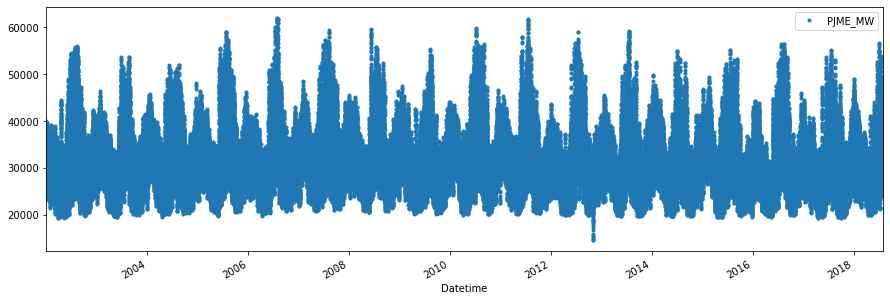

In [60]:
df.plot(style = ".", figsize = (15,5))
plt.show()

 ## Train / Test Split

In [61]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

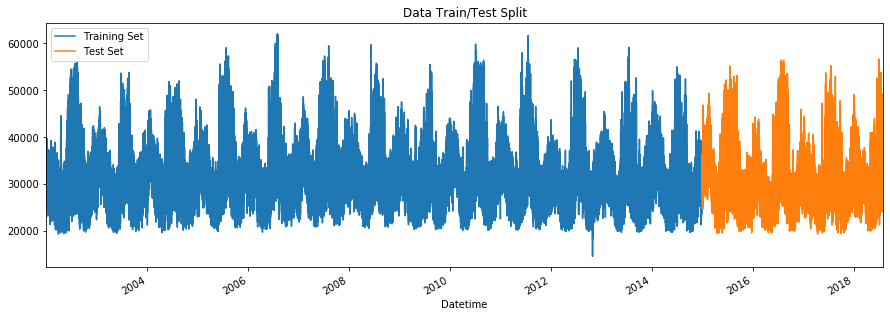

In [62]:
#2015e kadar olan verilerimizi train olarak kullanalım.
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

#train ve testin grafiğini çizdirelim.
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

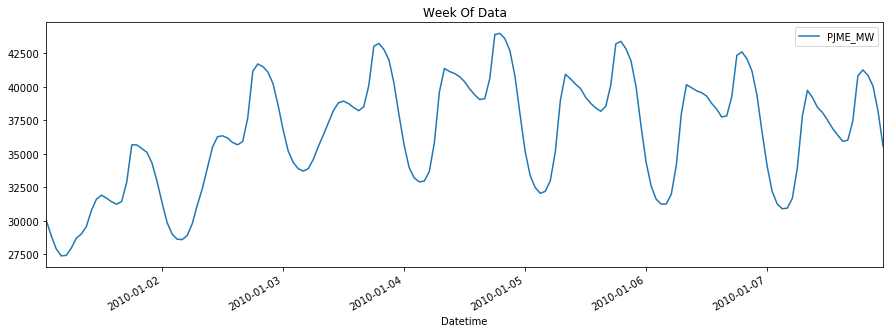

In [63]:
#Bu verilere bir de haftalık olarak bakalım
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Create Features

In [64]:
#datetime indeximizden farklı özellikler çıkarmamıza sağlayan bir fonksiyon yazalım.

def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour #0dan 23e kadar bir değer döndürür.
    df["dayofweek"] = df.index.dayofweek #0dan 6ya kadar bir değer döndürür. 0 = monday, 6 = sunday
    df["quarter"] = df.index.quarter #yılı 4e böler.
    df["month"] = df.index.month #1den 12ye kadar bir değer döndürür.
    df["year"] = df.index.year #yılı döndürür
    df["dayofyear"] = df.index.dayofyear #1den 365e kadar bir değer döndürür
    
    return df

df = create_features(df)

In [65]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [66]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2


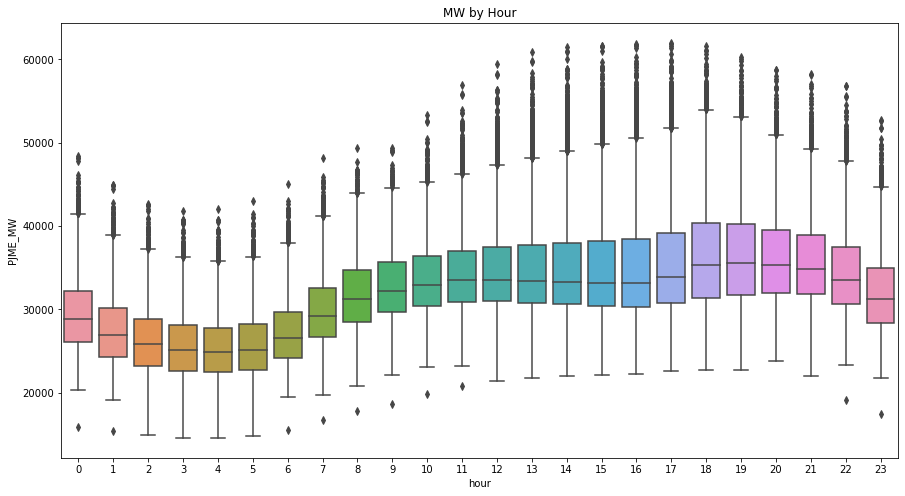

In [67]:
#Şimdi veriyi biraz daha anlamak için grafikler çizdirelim.
fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data = df, x = "hour", y = "PJME_MW")
ax.set_title('MW by Hour')
plt.show()

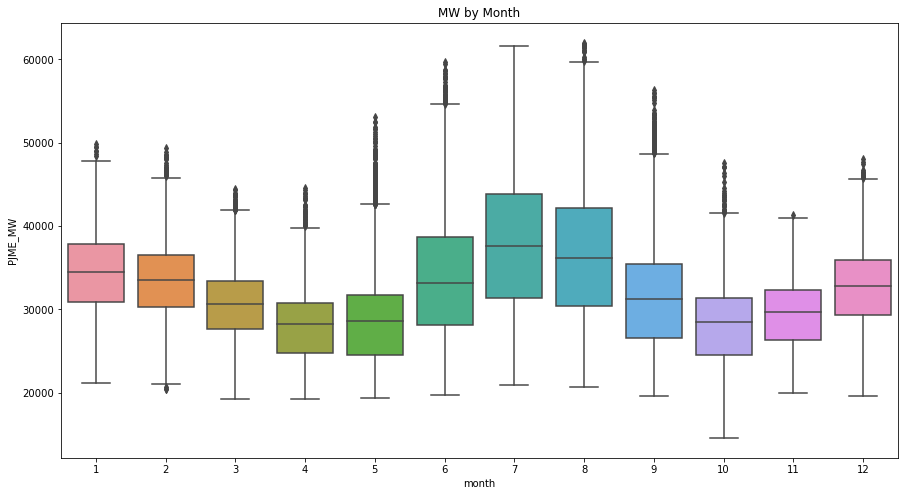

In [68]:
fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data = df, x = "month", y = "PJME_MW")
ax.set_title('MW by Month')
plt.show()

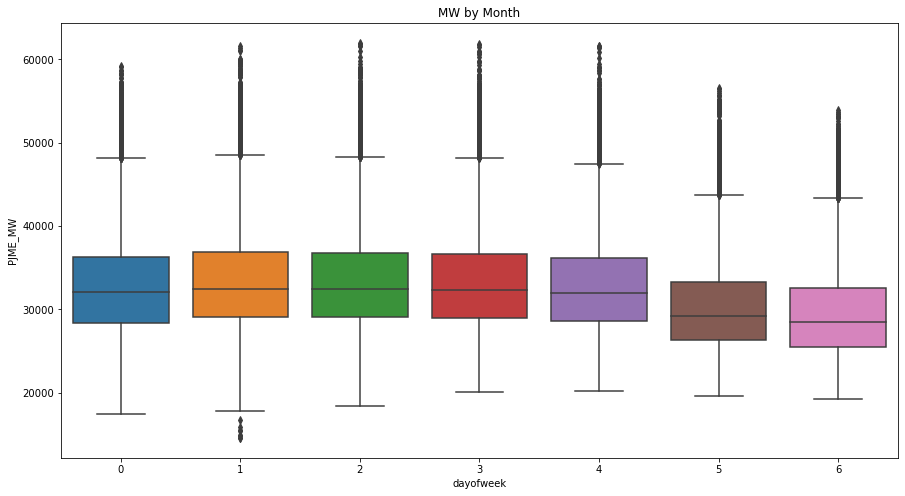

In [69]:
fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data = df, x = "dayofweek", y = "PJME_MW")
ax.set_title('MW by Month')
plt.show()

## Model Oluşturma

In [70]:
#öncelikle test ve train setlerimizi create feature fonksiyonuma sokalım
train = create_features(train)
test = create_features(test)

In [71]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [72]:
Features = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
Target = 'PJME_MW'

In [73]:
X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

In [83]:
#xgboostu kullanacağız.
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = True)

[0]	validation_0-rmse:23192.08347	validation_1-rmse:22262.72116
[1]	validation_0-rmse:16420.93235	validation_1-rmse:15523.28748
[2]	validation_0-rmse:11738.22738	validation_1-rmse:10902.11140
[3]	validation_0-rmse:8540.54141	validation_1-rmse:7809.80731
[4]	validation_0-rmse:6406.33278	validation_1-rmse:5886.97003
[5]	validation_0-rmse:5020.18414	validation_1-rmse:4712.54530
[6]	validation_0-rmse:4115.48568	validation_1-rmse:4193.11193
[7]	validation_0-rmse:3582.20742	validation_1-rmse:3953.68877
[8]	validation_0-rmse:3261.69940	validation_1-rmse:3796.80086
[9]	validation_0-rmse:3081.02460	validation_1-rmse:3777.59061
[10]	validation_0-rmse:2982.98557	validation_1-rmse:3763.35259
[11]	validation_0-rmse:2888.50281	validation_1-rmse:3809.64469
[12]	validation_0-rmse:2840.45869	validation_1-rmse:3810.92832
[13]	validation_0-rmse:2794.92469	validation_1-rmse:3833.23047
[14]	validation_0-rmse:2768.03577	validation_1-rmse:3826.84933
[15]	validation_0-rmse:2747.60912	validation_1-rmse:3839.80

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [80]:
#Hataların düşmeye başladığını gördük ama 10.adımdan sonra validation set hatası artmaya başladı.OVERFITTING.
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)


[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Önemli özelliği seçmek

In [39]:
#hangi özelliğimiz ne kadar kullanılmış onu görerek başlayalım.
df_imp = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
df_imp

,importance
hour,0.448804
dayofweek,0.158668
quarter,0.033319
month,0.228156
year,0.022634
dayofyear,0.108419


In [41]:
df_imp.sort_values("importance",ascending = False)

,importance
hour,0.448804
month,0.228156
dayofweek,0.158668
dayofyear,0.108419
quarter,0.033319
year,0.022634


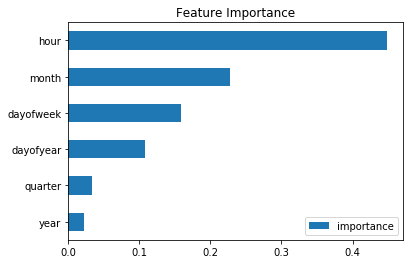

In [42]:
df_imp.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [43]:
#En önemli özelliğimizin 'hour' özelliği olduğunu görüyoruz.

In [44]:
test['prediction'] = reg.predict(X_test)
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score: {score:0.2f}')

RMSE Score: 3715.93


In [46]:
#Hatalarımızı hesaplayalım. Öncelikle en kötü tahminlerimizi sıralayalım.
test['error'] = np.abs(test[Target] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
2018-01-06    10903.514486
2015-02-20    10818.344727
2016-08-11    10390.962891
2018-01-07    10189.657715
2017-05-19    10180.837646
Name: error, dtype: float64

In [47]:
#En iyi tahminlerimize bakalım.
test.groupby(['date'])['error'].mean().sort_values().head(10)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
2015-09-25    502.371094
2015-10-28    507.922445
2017-05-02    514.495768
2017-06-16    524.565267
2017-12-08    527.530436
Name: error, dtype: float64